In [1]:
import os

import numpy as np

from matplotlib import pyplot as plt

import pickle
from IPython.display import clear_output

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE

from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

from torchvision.datasets.vision import VisionDataset

In [2]:
device = "cuda"

In [11]:
RUN_TSNE = True
RUN_KNN = True
RUN_ENERGY = True
RUN_LOGREG = True

SIMCLR_MODEL_NAME = "SIG-SimCLR-240.pt"

DATASET = "sig"
TRAIN = False

if DATASET == "badnets":
    TARGET_CLASS = 1
    DATASET_NAME = "BadNets"
elif DATASET == "wanet":
    TARGET_CLASS = 0
    DATASET_NAME = "WaNet"
elif DATASET == "sig":
    TARGET_CLASS = 0
    DATASET_NAME = "SIG"
else:
    raise Exception("Invalid dataset")

## Poison dataset

In [4]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=TRAIN)

if DATASET == "badnets":
    poison_dataset = BadNetsDataset(dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
elif DATASET == "wanet":
    poison_dataset = WaNetDataset(dataset, TARGET_CLASS, seed=1)
elif DATASET == "sig":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, seed=1)
else:
    raise Exception("Invalid dataset")

batch_size = 256
dataloader = DataLoader(poison_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Load SimCLR model

In [5]:
model = SimClrBackbone()

out = os.path.join('./saved_models/', SIMCLR_MODEL_NAME)
checkpoint = torch.load(out, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SimClrBackbone(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): C

## Extract features for all images

In [9]:
simclr_feature_size = 128

features = np.zeros((len(dataset), simclr_feature_size))
labels_poison = np.zeros((len(dataset)))
labels_true = np.zeros((len(dataset)))

for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

    with torch.no_grad():
        features_batch = model(img.to(device)).cpu().data.numpy()
        
    features[i*batch_size : i*batch_size+len(features_batch)] = features_batch
    labels_poison[i*batch_size : i*batch_size+len(labels_batch_poison)] = labels_batch_poison.long()
    labels_true[i*batch_size : i*batch_size+len(labels_batch_true)] = labels_batch_true.long()

labels_poison = labels_poison.astype(int)
labels_true = labels_poison.astype(int)
num_classes = int(max(labels_poison).item())

## Plot t-SNE features

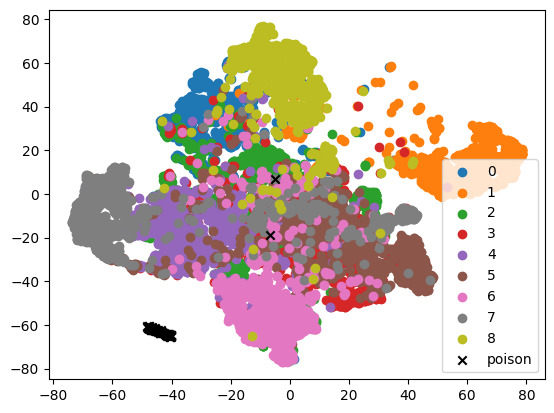

In [12]:
if RUN_TSNE:

    # label poison examples as 10
    labels = labels_true[:]
    labels[[poison_dataset.is_poison(i) for i in range(len(labels))]] = 10

    # Plot only a subset
    subset_size = 10000
    features_subset = features[:subset_size]
    labels_subset = labels[:subset_size]
        
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features_subset)

    for i in range(num_classes):
        plt.scatter(tsne_features[labels_subset==i,1], tsne_features[labels_subset==i,0])
    plt.scatter(tsne_features[labels_subset==10,1], tsne_features[labels_subset==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

## kNN clean

In [13]:
if RUN_KNN:

    from sklearn.neighbors import KNeighborsClassifier

    examples_per_class = len(dataset) / num_classes

    knn = KNeighborsClassifier(n_neighbors=int(examples_per_class/2))
    knn.fit(features, labels_poison)

In [14]:
if RUN_KNN:

    tp = 0
    fp = 0
    tn = 0
    fn = 0

    predicted_labels = []

    count_poison = 0

    for i in range(len(dataset)):
        feature = features[i]
        poison_label = labels_poison[i]
        true_label = labels_true[i]
        predicted_label = knn.predict(np.expand_dims(feature,0))[0]

        predicted_labels.append(predicted_label)

        true_poison = poison_dataset.is_poison(i)
        predicted_poison = poison_label != predicted_label

        if true_poison: count_poison += 1

        if true_poison and predicted_poison:
            tp += 1
        elif not true_poison and predicted_poison:
            fp += 1
        elif true_poison and not predicted_poison:
            fn += 1
        else:
            tn += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"{i} / {len(dataset)}")
            print(f"\t {tp} \t {fp}")
            print(f"\t {fn} \t {tn}")

            fnr = fn/(fn+tp) if fn+tp!=0 else 0
            tnr = tn/(tn+fp) if tn+fp!=0 else 0
            poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
            print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
            print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
            print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

    clear_output(wait=True)
    print(f"{len(dataset)} / {len(dataset)}")
    print(f"\t {tp} \t {fp}")
    print(f"\t {fn} \t {tn}")

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
    print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
    print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
    print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

600 / 10000
	 5 	 140
	 3 	 453
Percentage of poisoned images (out of all poisoned) kept:  37.50%
Percentage of clean images (out of all clean) kept:  76.39%
Percentage of remaining poisoned images (out of all remaining):  0.66%


KeyboardInterrupt: 

------------------------------------

CIFAR-10 train \
BadNets 

    50000 / 50000
        4905 	 9481
        95 	 35519
    Percentage of poisoned images (out of all poisoned) kept:  1.90%
    Percentage of clean images (out of all clean) kept:  78.93%
    Percentage of remaining poisoned images (out of all remaining):  0.27%

CIFAR-10 test \
BadNets 

    10000 / 10000
        960 	 2056
        40 	 6944
    Percentage of poisoned images (out of all poisoned) kept:  4.00%
    Percentage of clean images (out of all clean) kept:  77.16%
    Percentage of remaining poisoned images (out of all remaining):  0.57%

------------------------------------

CIFAR-10 train \
WaNet 

    50000 / 50000
        3975 	 14331
        1025 	 30669
    Percentage of poisoned images (out of all poisoned) kept:  20.50%
    Percentage of clean images (out of all clean) kept:  68.15%
    Percentage of remaining poisoned images (out of all remaining):  3.23%

CIFAR-10 test \
WaNet 

    10000 / 10000
        712 	 3058
        288 	 5942
    Percentage of poisoned images (out of all poisoned) kept:  28.80%
    Percentage of clean images (out of all clean) kept:  66.02%
    Percentage of remaining poisoned images (out of all remaining):  4.62%

------------------------------------

CIFAR-10 test \
SIG

    50000 / 50000
        0 	 9195
        500 	 40305
    Percentage of poisoned images (out of all poisoned) kept:  100.00%
    Percentage of clean images (out of all clean) kept:  81.42%
    Percentage of remaining poisoned images (out of all remaining):  1.23%

In [266]:
if RUN_KNN:

    save_name = f"__NEW__{DATASET_NAME}-kNN-{'train' if TRAIN else 'test'}"

    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(predicted_labels, f)

## Energy clean

In [267]:
class EnergyClassifier():

    def __init__(self, t=1):
        self.t = t

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        self.C = int(np.max(y))
        self.Ic = {c:[i for i in range(len(y)) if y[i]==c] for c in range(self.C)}
        
    def predict_index(self, i):

        # consider improving with numpy

        xi = self.X[i]

        exp_all = np.exp([xi*self.X[k]/self.t for k in range(len(self.X))])
        sum_exp_all_except_xi = np.sum([exp_all[k] for k in range(len(self.X)) if k!=i])
        mean_exp_c = [np.mean([exp_all[k] for k in self.Ic[c] if k!=i]) for c in range(self.C)]
    
        Scs = mean_exp_c / sum_exp_all_except_xi
        return np.argmax(Scs)

if DATASET == "badnets":
    T = 100
elif DATASET == "wanet":
    T = 10
elif DATASET == "sig":
    T = 1
else:
    raise Exception("Invalid dataset")

if RUN_ENERGY:
    energy = EnergyClassifier(t=T)
    energy.fit(features, labels_poison)

In [268]:
if RUN_ENERGY:
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    predicted_labels = []

    for i in range(len(dataset)):
        poison_label = labels_poison[i]
        true_label = labels_true[i]
        predicted_label = energy.predict_index(i)

        predicted_labels.append(predicted_label)

        true_poison = poison_dataset.is_poison(i)
        predicted_poison = poison_label != predicted_label

        if true_poison and predicted_poison:
            tp += 1
        elif not true_poison and predicted_poison:
            fp += 1
        elif true_poison and not predicted_poison:
            fn += 1
        else:
            tn += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"{i} / {len(dataset)}")
            print(f"\t {tp} \t {fp}")
            print(f"\t {fn} \t {tn}")

            fnr = fn/(fn+tp) if fn+tp!=0 else 0
            tnr = tn/(tn+fp) if tn+fp!=0 else 0
            poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
            print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
            print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
            print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")


    clear_output(wait=True)
    print(f"{len(dataset)} / {len(dataset)}")
    print(f"\t {tp} \t {fp}")
    print(f"\t {fn} \t {tn}")

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
    print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
    print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
    print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

CIFAR-10 train \
BadNets

	50000 / 50000
		4618 	 12732
		382 	 32268
	Percentage of poisoned images (out of all poisoned) kept:  7.64%
	Percentage of clean images (out of all clean) kept:  71.71%
	Percentage of remaining poisoned images (out of all remaining):  1.17%

CIFAR-10 test \
BadNets

	10000 / 10000
		920 	 2585
		80 	 6415
	Percentage of poisoned images (out of all poisoned) kept:  8.00%
	Percentage of clean images (out of all clean) kept:  71.28%
	Percentage of remaining poisoned images (out of all remaining):  1.23%

--------------------------------------------------------------------------------

CIFAR-10 train \
WaNet

	50000 / 50000
		4725 	 14096
		275 	 30904
	Percentage of poisoned images (out of all poisoned) kept:  5.50%
	Percentage of clean images (out of all clean) kept:  68.68%
	Percentage of remaining poisoned images (out of all remaining):  0.88%

CIFAR-10 test \
WaNet

	10000 / 10000
		951 	 2851
		49 	 6149
	Percentage of poisoned images (out of all poisoned) kept:  4.90%
	Percentage of clean images (out of all clean) kept:  68.32%
	Percentage of remaining poisoned images (out of all remaining):  0.79%

--------------------------------------------------------------------------------

CIFAR-10 train \
SIG

	50000 / 50000
		2 	 15777
		498 	 33723
	Percentage of poisoned images (out of all poisoned) kept:  99.60%
	Percentage of clean images (out of all clean) kept:  68.13%
	Percentage of remaining poisoned images (out of all remaining):  1.46%

In [269]:
if RUN_ENERGY:

    save_name = f"__NEW__{DATASET_NAME}-Energy-{'train' if TRAIN else 'test'}"

    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(predicted_labels, f)

## LogReg clean

In [15]:
class LogReg(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [16]:
class SimClrFeaturesDataset(VisionDataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    def __len__(self):
        return len(self.features)

In [22]:
if RUN_LOGREG:
    
    BATCH_SIZE = 1024
    NUM_MODELS = 50
    EPOCHS = 500

    classifications = np.zeros((NUM_MODELS, len(features)))

    for num_model in range(NUM_MODELS):
        print(f"Learning logistic regression model {num_model+1}/{NUM_MODELS}")
        simclr_features_dataset = SimClrFeaturesDataset(features, labels_poison)
        dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=True) 
        model = LogReg(128, 10)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-3)
        criterion = torch.nn.CrossEntropyLoss()
        
        # train
        for epoch in range(EPOCHS):
            correct = 0
            for i, (batch_features, batch_labels) in enumerate(dataloader):
                batch_features, batch_labels = batch_features.float(), batch_labels.long()

                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == batch_labels).sum()
            accuracy = 100 * (correct.item()) / len(simclr_features_dataset)
        print(f"Accuracy: {accuracy}")

        # get model classifications
        dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=False) 
        for i, (batch_features, batch_labels) in enumerate(dataloader):
            batch_features, batch_labels = batch_features.float(), batch_labels.long()

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.numpy()
            classifications[num_model, (i*BATCH_SIZE):(i*BATCH_SIZE+len(predicted))] = predicted


Learning logistic regression model 1/100
Accuracy: 79.0
Learning logistic regression model 2/100
Accuracy: 78.27
Learning logistic regression model 3/100


KeyboardInterrupt: 

In [21]:
labels_poison_repeated = np.tile(labels_poison, (NUM_MODELS,1))
misclassifications = np.sum(classifications != labels_poison_repeated, axis=0)


poisoned_vector = np.array([poison_dataset.is_poison(i) for i in range(len(labels))])


misclassifications_poisoned = misclassifications[poisoned_vector]
misclassifications_clean = misclassifications[np.invert(poisoned_vector)]

print(misclassifications_poisoned.shape)
print(misclassifications_clean.shape)

print(np.average(misclassifications_poisoned))
print(np.average(misclassifications_clean))

(100,)
(9900,)
16.32
15.426565656565657
